In [2]:
import numpy as np
import tensorflow as tf
import random as rn
import numpy as np

import os

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)

from keras import backend as K

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from keras.layers import Input, Dense,LSTM,RepeatVector,GRU,Dropout,Reshape
from keras.layers import*
from keras.models import Model
from keras.models import Sequential
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
from math import sqrt
import random
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [54]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[:,0][-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = []
	for x in X:
   		 new_row = new_row+[i for i in x]
            
	new_row.append(value) 
	new_row_2 = np.array(new_row)
	new_row_2 = new_row_2.reshape((1,new_row_2.shape[0]))
	inverted = scaler.inverse_transform(new_row_2)
	return inverted[0, -1]


def create_dataset(dataset,features, look_back=1):
	dataset = np.insert(dataset,[0]*look_back,0)    
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	dataY= np.array(dataY)        
	dataY = np.reshape(dataY,(dataY.shape[0],features))
	dataset = np.concatenate((dataX,dataY),axis=1)  
	return dataset



# convert series to supervised learning
def series_to_supervised(data,features, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	x = np.zeros(features, dtype=np.int)
	for i in range(n_in):
		data = np.insert(data,x,0)
	data = data.reshape(int(data.shape[0]/features),features) 
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(batch_size, X.shape[0], X.shape[1])
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


# def read_data(): 

	
# 	window_size = 0
# 	features = 8


# 	series = read_csv('pollution.csv', header=0, index_col=0)	
# 	raw_values = series.values

# 	# integer encode wind direction
# 	encoder = LabelEncoder()
# 	raw_values[:,4] = encoder.fit_transform(raw_values[:,4])

# 	# transform data to be stationary
# 	diff = difference(raw_values, 1)


# 	dataset = diff.values
# 	dataset = create_dataset(dataset,features,window_size)


# 	return dataset,raw_values

In [55]:
space = {'seq_len':hp.choice('seq_len',[5,10,15,20,25,30]),
         'epochs_pre':hp.choice('epochs_pre',[i for i in range(50,1000)]),
         'epochs_finetune':hp.choice('epochs_finetune',[i for i in range(50,500)]),
         'units':hp.choice('units',[i for i in range(1,50)]),
         'dropout':hp.choice('dropout',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
         'batch_size':hp.choice('batch_size',[73, 146, 219])}

In [56]:
params = {'seq_len': 10,
          'epochs_pre': 100,
          'epochs_finetune': 50,
          'units': 20,
          'dropout': 0.2,
          'batch_size': 73}

In [57]:
hidden_layers = [35,49,4]
batch_size = 219
dropout = 0.2
seq_len = 25
epochs_pre  = [625,115,933]
epochs_finetune = 197
window_size = 0
features = 8

In [58]:
dataset

array([[19, 1, 0.0, ..., 0.8900000000000001, 0, 0],
       [11, 4, -1.0, ..., 0.8899999999999997, 0, 0],
       [22, 4, 0.0, ..., 1.7900000000000005, 1, 0],
       ...,
       [0, 0, 0.0, ..., 4.9199999999999875, 0, 0],
       [-2, 0, -1.0, ..., 4.02000000000001, 0, 0],
       [4, 1, 1.0, ..., 3.1299999999999955, 0, 0]], dtype=object)

In [59]:
series = read_csv('pollution.csv', header=0, index_col=0)
raw_values = series.values

# integer encode wind direction
encoder = LabelEncoder()
raw_values[:,4] = encoder.fit_transform(raw_values[:,4])

# transform data to be stationary
diff = difference(raw_values, 1)


dataset = diff.values
dataset = create_dataset(dataset,features,window_size)

In [60]:
# frame as supervised learning
reframed = series_to_supervised(dataset,features, seq_len, 1)
drop = [i for  i in  range(seq_len*features+1,((seq_len+1)*features))]
reframed.drop(reframed.columns[drop], axis=1, inplace=True)
reframed = reframed.values

# split into train and test sets
train_size = 365*24*4
train, test = reframed[0:train_size], reframed[train_size:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# split into input and outputs
x_train,y_train = train_scaled[:,0:-1],train_scaled[:,-1]
x_test,y_test = test_scaled[:,0:-1],test_scaled[:,-1]

# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0],seq_len,features)
x_test = x_test.reshape(x_test.shape[0],seq_len,features)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(35040, 25, 8) (35040,) (8759, 25, 8) (8759,)


In [61]:
print('\nstart pretraining')
print('===============')

timesteps = x_train.shape[1]
input_dim = x_train.shape[2]
trained_encoder = []
x_train_temp = x_train


start pretraining


In [64]:
print('>> 1 LAYERS')
hidden = hidden_layers[0]
epochs = epochs_pre[0]

>> 1 LAYERS


In [71]:
print(f'pretrain Autoencoder: {0} ----> Encoder: {hidden} ----> Epochs: {epochs}')
print(x_train_temp.shape)
print('=============================================================')

inputs = Input(
    # (219, 25, 8)
    batch_shape=(batch_size, timesteps, x_train_temp.shape[2]))
encoded = CuDNNLSTM(
    hidden, # 35
    batch_input_shape=(batch_size, timesteps, x_train_temp.shape[2]),
    stateful = False)(inputs)
decoded = RepeatVector(timesteps)(encoded) 
decoded = CuDNNLSTM(input_dim, stateful=False, return_sequences=True)(decoded)

AE = Model(inputs, decoded)

encoder = Model(inputs,encoded)

AE.compile(loss='mean_squared_error', optimizer='Adam')

encoder.compile(loss='mean_squared_error', optimizer='Adam')

AE.summary()

pretrain Autoencoder: 0 ----> Encoder: 35 ----> Epochs: 625
(35040, 25, 8)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (219, 25, 8)              0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (219, 35)                 6300      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (219, 25, 35)             0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (219, 25, 8)              1440      
Total params: 7,740
Trainable params: 7,740
Non-trainable params: 0
_________________________________________________________________


In [82]:
AE.fit(
    x_train_temp, 
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/625
35040/35040 [==============================] - 2s 65us/step - loss: 0.0400
Epoch 2/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0213
Epoch 3/625
35040/35040 [==============================] - 1s 39us/step - loss: 0.0211
Epoch 4/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0210
Epoch 5/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0209
Epoch 6/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0208
Epoch 7/625
35040/35040 [==============================] - 1s 42us/step - loss: 0.0207
Epoch 8/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0206
Epoch 9/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0205
Epoch 10/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0205
Epoch 11/625
35040/35040 [==============================] - 1s 42us/step - loss: 0.0205
Epoch 12/625
35040/35040 [===============

35040/35040 [==============================] - 1s 42us/step - loss: 0.0187
Epoch 94/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0187
Epoch 95/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0187
Epoch 96/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0187
Epoch 97/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0186
Epoch 98/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0187
Epoch 99/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0186
Epoch 100/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0186
Epoch 101/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0186
Epoch 102/625
35040/35040 [==============================] - 1s 42us/step - loss: 0.0186
Epoch 103/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0186
Epoch 104/625
35040/35040 [==============

35040/35040 [==============================] - 1s 39us/step - loss: 0.0183
Epoch 186/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0183
Epoch 187/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0183
Epoch 188/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0183
Epoch 189/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0183
Epoch 190/625
35040/35040 [==============================] - 1s 39us/step - loss: 0.0183
Epoch 191/625
35040/35040 [==============================] - 1s 39us/step - loss: 0.0183
Epoch 192/625
35040/35040 [==============================] - 1s 38us/step - loss: 0.0183
Epoch 193/625
35040/35040 [==============================] - 1s 39us/step - loss: 0.0183
Epoch 194/625
35040/35040 [==============================] - 1s 39us/step - loss: 0.0183
Epoch 195/625
35040/35040 [==============================] - 1s 39us/step - loss: 0.0183
Epoch 196/625
35040/35040 [========

35040/35040 [==============================] - 2s 43us/step - loss: 0.0182
Epoch 278/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0182
Epoch 279/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0182
Epoch 280/625
35040/35040 [==============================] - 1s 39us/step - loss: 0.0182
Epoch 281/625
35040/35040 [==============================] - 1s 39us/step - loss: 0.0182
Epoch 282/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0182
Epoch 283/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0182
Epoch 284/625
35040/35040 [==============================] - 1s 42us/step - loss: 0.0182
Epoch 285/625
35040/35040 [==============================] - 1s 42us/step - loss: 0.0182
Epoch 286/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0182
Epoch 287/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0182
Epoch 288/625
35040/35040 [========

35040/35040 [==============================] - 1s 41us/step - loss: 0.0182
Epoch 370/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0182
Epoch 371/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0182
Epoch 372/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0182
Epoch 373/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0182
Epoch 374/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0182
Epoch 375/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0182
Epoch 376/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0182
Epoch 377/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0182
Epoch 378/625
35040/35040 [==============================] - 1s 42us/step - loss: 0.0182
Epoch 379/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0181
Epoch 380/625
35040/35040 [========

35040/35040 [==============================] - 1s 42us/step - loss: 0.0181
Epoch 462/625
35040/35040 [==============================] - 1s 42us/step - loss: 0.0181
Epoch 463/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0181
Epoch 464/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0181
Epoch 465/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0181
Epoch 466/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0181
Epoch 467/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0181
Epoch 468/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0181
Epoch 469/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0181
Epoch 470/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0181
Epoch 471/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0181
Epoch 472/625
35040/35040 [========

35040/35040 [==============================] - 1s 40us/step - loss: 0.0181
Epoch 554/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0181
Epoch 555/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0181
Epoch 556/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0181
Epoch 557/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0181
Epoch 558/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0181
Epoch 559/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0181
Epoch 560/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0181
Epoch 561/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0181
Epoch 562/625
35040/35040 [==============================] - 1s 40us/step - loss: 0.0181
Epoch 563/625
35040/35040 [==============================] - 1s 41us/step - loss: 0.0181
Epoch 564/625
35040/35040 [========

In [84]:
# store trained encoder and its weights
trained_encoder.append(
    (AE.layers[1], AE.layers[1].get_weights())
)

# update training data
x_train_temp = encoder.predict(x_train_temp, batch_size=batch_size)

In [89]:
x_train_temp.shape

(35040, 35)

In [90]:
# reshape encoded input to 3D
inputs = Input(shape = (x_train_temp.shape[1],)) 
reshape = RepeatVector(timesteps)(inputs)
Repeat = Model(inputs,reshape)

x_train_temp = Repeat.predict(x_train_temp, batch_size=batch_size)

In [92]:
x_train_temp.shape

(35040, 25, 35)

In [93]:
print('>> 2 LAYERS')
hidden = hidden_layers[1]
epochs = epochs_pre[1]

>> 2 LAYERS


In [94]:
print(f'pretrain Autoencoder: {1} ----> Encoder: {hidden} ----> Epochs: {epochs}')
print(x_train_temp.shape)
print('=============================================================')

inputs = Input(
    # (219, 25, 35)
    batch_shape=(batch_size, timesteps, x_train_temp.shape[2]))
encoded = CuDNNLSTM(
    hidden, # 49
    batch_input_shape=(batch_size, timesteps, x_train_temp.shape[2]),
    stateful = False)(inputs)
decoded = RepeatVector(timesteps)(encoded) 
decoded = CuDNNLSTM(input_dim, stateful=False, return_sequences=True)(decoded)

AE = Model(inputs, decoded)

encoder = Model(inputs,encoded)

AE.compile(loss='mean_squared_error', optimizer='Adam')

encoder.compile(loss='mean_squared_error', optimizer='Adam')

AE.summary()

pretrain Autoencoder: 1 ----> Encoder: 49 ----> Epochs: 115
(35040, 25, 35)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (219, 25, 35)             0         
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (219, 49)                 16856     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (219, 25, 49)             0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (219, 25, 8)              1888      
Total params: 18,744
Trainable params: 18,744
Non-trainable params: 0
_________________________________________________________________


In [96]:
AE.fit(
    x_train_temp, 
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/115
35040/35040 [==============================] - 2s 48us/step - loss: 0.0405
Epoch 2/115
35040/35040 [==============================] - 1s 43us/step - loss: 0.0209
Epoch 3/115
35040/35040 [==============================] - 1s 42us/step - loss: 0.0207
Epoch 4/115
35040/35040 [==============================] - 1s 42us/step - loss: 0.0206
Epoch 5/115
35040/35040 [==============================] - 1s 42us/step - loss: 0.0205
Epoch 6/115
35040/35040 [==============================] - 2s 44us/step - loss: 0.0205
Epoch 7/115
35040/35040 [==============================] - 2s 46us/step - loss: 0.0205
Epoch 8/115
35040/35040 [==============================] - 2s 43us/step - loss: 0.0204
Epoch 9/115
35040/35040 [==============================] - 1s 42us/step - loss: 0.0204
Epoch 10/115
35040/35040 [==============================] - 1s 42us/step - loss: 0.0204
Epoch 11/115
35040/35040 [==============================] - 1s 42us/step - loss: 0.0203
Epoch 12/115
35040/35040 [===============

35040/35040 [==============================] - 1s 42us/step - loss: 0.0183
Epoch 95/115
35040/35040 [==============================] - 1s 43us/step - loss: 0.0183
Epoch 96/115
35040/35040 [==============================] - 1s 43us/step - loss: 0.0182
Epoch 97/115
35040/35040 [==============================] - 1s 42us/step - loss: 0.0183
Epoch 98/115
35040/35040 [==============================] - 2s 43us/step - loss: 0.0182
Epoch 99/115
35040/35040 [==============================] - 2s 43us/step - loss: 0.0182
Epoch 100/115
35040/35040 [==============================] - 1s 42us/step - loss: 0.0183
Epoch 101/115
35040/35040 [==============================] - 1s 41us/step - loss: 0.0182
Epoch 102/115
35040/35040 [==============================] - 1s 41us/step - loss: 0.0182
Epoch 103/115
35040/35040 [==============================] - 1s 41us/step - loss: 0.0183
Epoch 104/115
35040/35040 [==============================] - 1s 42us/step - loss: 0.0182
Epoch 105/115
35040/35040 [=============

In [97]:
# store trained encoder and its weights
trained_encoder.append(
    (AE.layers[1], AE.layers[1].get_weights())
)

# update training data
x_train_temp = encoder.predict(x_train_temp, batch_size=batch_size)

In [98]:
x_train_temp.shape

(35040, 49)

In [99]:
# reshape encoded input to 3D
inputs = Input(shape = (x_train_temp.shape[1],)) 
reshape = RepeatVector(timesteps)(inputs)
Repeat = Model(inputs,reshape)

x_train_temp = Repeat.predict(x_train_temp, batch_size=batch_size)

In [100]:
x_train_temp.shape

(35040, 25, 49)

In [101]:
print('>> 3 LAYERS')
hidden = hidden_layers[2]
epochs = epochs_pre[2]

>> 3 LAYERS


In [102]:
print(f'pretrain Autoencoder: {2} ----> Encoder: {hidden} ----> Epochs: {epochs}')
print(x_train_temp.shape)
print('=============================================================')

inputs = Input(
    # (219, 25, 49)
    batch_shape=(batch_size, timesteps, x_train_temp.shape[2]))
encoded = CuDNNLSTM(
    hidden, # 4
    batch_input_shape=(batch_size, timesteps, x_train_temp.shape[2]),
    stateful = False)(inputs)
decoded = RepeatVector(timesteps)(encoded) 
decoded = CuDNNLSTM(input_dim, stateful=False, return_sequences=True)(decoded)

AE = Model(inputs, decoded)

encoder = Model(inputs,encoded)

AE.compile(loss='mean_squared_error', optimizer='Adam')

encoder.compile(loss='mean_squared_error', optimizer='Adam')

AE.summary()

pretrain Autoencoder: 2 ----> Encoder: 4 ----> Epochs: 933
(35040, 25, 49)
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (219, 25, 49)             0         
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (219, 4)                  880       
_________________________________________________________________
repeat_vector_6 (RepeatVecto (219, 25, 4)              0         
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (219, 25, 8)              448       
Total params: 1,328
Trainable params: 1,328
Non-trainable params: 0
_________________________________________________________________


In [105]:
AE.fit(
    x_train_temp, 
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/933
35040/35040 [==============================] - 2s 50us/step - loss: 0.1551
Epoch 2/933
35040/35040 [==============================] - 1s 43us/step - loss: 0.0361
Epoch 3/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0269
Epoch 4/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0252
Epoch 5/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0243
Epoch 6/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0237
Epoch 7/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0232
Epoch 8/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0229
Epoch 9/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0225
Epoch 10/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0222: 0s - loss: 0.
Epoch 11/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0219
Epoch 12/933
35040/35040 [

35040/35040 [==============================] - 1s 41us/step - loss: 0.0194
Epoch 95/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0194
Epoch 96/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0194
Epoch 97/933
35040/35040 [==============================] - 1s 39us/step - loss: 0.0194
Epoch 98/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0194
Epoch 99/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0194
Epoch 100/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0194
Epoch 101/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0194
Epoch 102/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0194
Epoch 103/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0194
Epoch 104/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0194
Epoch 105/933
35040/35040 [=============

35040/35040 [==============================] - 1s 41us/step - loss: 0.0191
Epoch 187/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0191
Epoch 188/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0191
Epoch 189/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0190
Epoch 190/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0190
Epoch 191/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0190
Epoch 192/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0190
Epoch 193/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0190
Epoch 194/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0190
Epoch 195/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0190
Epoch 196/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0191
Epoch 197/933
35040/35040 [========

35040/35040 [==============================] - 1s 41us/step - loss: 0.0187
Epoch 279/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0187
Epoch 280/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0187
Epoch 281/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0186
Epoch 282/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0187
Epoch 283/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0187
Epoch 284/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0186
Epoch 285/933
35040/35040 [==============================] - 1s 43us/step - loss: 0.0186
Epoch 286/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0186
Epoch 287/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0187
Epoch 288/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0187
Epoch 289/933
35040/35040 [========

35040/35040 [==============================] - 1s 40us/step - loss: 0.0186
Epoch 371/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0186
Epoch 372/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0186
Epoch 373/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0186
Epoch 374/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0186
Epoch 375/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0186
Epoch 376/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0186
Epoch 377/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0186
Epoch 378/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0186
Epoch 379/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0186
Epoch 380/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0186
Epoch 381/933
35040/35040 [========

35040/35040 [==============================] - 1s 40us/step - loss: 0.0185
Epoch 463/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0185
Epoch 464/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0185
Epoch 465/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 466/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 467/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 468/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 469/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 470/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 471/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 472/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 473/933
35040/35040 [========

35040/35040 [==============================] - 1s 40us/step - loss: 0.0185
Epoch 555/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0185
Epoch 556/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0185
Epoch 557/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0185
Epoch 558/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0185
Epoch 559/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 560/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0185
Epoch 561/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 562/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 563/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0185
Epoch 564/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0185
Epoch 565/933
35040/35040 [========

35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 647/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 648/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 649/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0185
Epoch 650/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 651/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0185
Epoch 652/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 653/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 654/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 655/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 656/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 657/933
35040/35040 [========

35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 739/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 740/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0184
Epoch 741/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0185
Epoch 742/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 743/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 744/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 745/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0184
Epoch 746/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0184
Epoch 747/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 748/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 749/933
35040/35040 [========

35040/35040 [==============================] - 1s 42us/step - loss: 0.0184
Epoch 831/933
35040/35040 [==============================] - 2s 43us/step - loss: 0.0184
Epoch 832/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 833/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0184
Epoch 834/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0184
Epoch 835/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 836/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0184
Epoch 837/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 838/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 839/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0184
Epoch 840/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 841/933
35040/35040 [========

35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 923/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 924/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 925/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 926/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 927/933
35040/35040 [==============================] - 1s 40us/step - loss: 0.0184
Epoch 928/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 929/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 930/933
35040/35040 [==============================] - 1s 41us/step - loss: 0.0184
Epoch 931/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0184
Epoch 932/933
35040/35040 [==============================] - 1s 42us/step - loss: 0.0184
Epoch 933/933
35040/35040 [========

In [106]:
# store trained encoder and its weights
trained_encoder.append(
    (AE.layers[1], AE.layers[1].get_weights())
)

# update training data
x_train_temp = encoder.predict(x_train_temp, batch_size=batch_size)

In [107]:
x_train_temp.shape

(35040, 4)

In [108]:
# reshape encoded input to 3D
inputs = Input(shape = (x_train_temp.shape[1],)) 
reshape = RepeatVector(timesteps)(inputs)
Repeat = Model(inputs,reshape)

x_train_temp = Repeat.predict(x_train_temp, batch_size=batch_size)

In [109]:
x_train_temp.shape

(35040, 25, 4)

In [110]:
# Fine-turning
print('\nFine-turning')
print('============')

l = len(trained_encoder)
#build finetuning model
model = Sequential()
for i,encod in enumerate(trained_encoder):
    model.add(encod[0])
    model.layers[-1].set_weights(encod[1])
    model.add(Dropout(dropout))
    if(i+1 != l): model.add(RepeatVector(timesteps))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam')

model.fit(
    x_train, 
    y_train, 
    epochs=epochs_finetune, 
    batch_size=batch_size, 
    verbose=1,
    shuffle=True
)


Fine-turning
Epoch 1/197
35040/35040 [==============================] - 3s 76us/step - loss: 0.0332
Epoch 2/197
35040/35040 [==============================] - 2s 59us/step - loss: 0.0023
Epoch 3/197
35040/35040 [==============================] - 2s 59us/step - loss: 0.0015
Epoch 4/197
35040/35040 [==============================] - 2s 60us/step - loss: 0.0012
Epoch 5/197
35040/35040 [==============================] - 2s 59us/step - loss: 0.0011
Epoch 6/197
35040/35040 [==============================] - 2s 58us/step - loss: 0.0011
Epoch 7/197
35040/35040 [==============================] - 2s 58us/step - loss: 0.0011
Epoch 8/197
35040/35040 [==============================] - 2s 57us/step - loss: 0.0011
Epoch 9/197
35040/35040 [==============================] - 2s 57us/step - loss: 0.0011
Epoch 10/197
35040/35040 [==============================] - 2s 57us/step - loss: 0.0011
Epoch 11/197
35040/35040 [==============================] - 2s 61us/step - loss: 0.0011
Epoch 12/197
35040/35040 [=

35040/35040 [==============================] - 2s 60us/step - loss: 0.0010
Epoch 94/197
35040/35040 [==============================] - 2s 57us/step - loss: 0.0010
Epoch 95/197
35040/35040 [==============================] - 2s 59us/step - loss: 0.0010
Epoch 96/197
35040/35040 [==============================] - 2s 58us/step - loss: 0.0010
Epoch 97/197
35040/35040 [==============================] - 2s 59us/step - loss: 0.0010
Epoch 98/197
35040/35040 [==============================] - 2s 59us/step - loss: 0.0010
Epoch 99/197
35040/35040 [==============================] - 2s 61us/step - loss: 0.0010
Epoch 100/197
35040/35040 [==============================] - 2s 59us/step - loss: 0.0010
Epoch 101/197
35040/35040 [==============================] - 2s 57us/step - loss: 0.0010
Epoch 102/197
35040/35040 [==============================] - 2s 57us/step - loss: 0.0010
Epoch 103/197
35040/35040 [==============================] - 2s 57us/step - loss: 0.0010
Epoch 104/197
35040/35040 [==============

35040/35040 [==============================] - 2s 59us/step - loss: 9.4521e-04
Epoch 184/197
35040/35040 [==============================] - 2s 58us/step - loss: 9.5205e-04
Epoch 185/197
35040/35040 [==============================] - 2s 59us/step - loss: 9.9982e-04
Epoch 186/197
35040/35040 [==============================] - 2s 60us/step - loss: 9.5317e-04
Epoch 187/197
35040/35040 [==============================] - 2s 61us/step - loss: 9.6451e-04
Epoch 188/197
35040/35040 [==============================] - 2s 59us/step - loss: 9.6294e-04
Epoch 189/197
35040/35040 [==============================] - 2s 60us/step - loss: 0.0011
Epoch 190/197
35040/35040 [==============================] - 2s 59us/step - loss: 0.0010
Epoch 191/197
35040/35040 [==============================] - 2s 59us/step - loss: 9.9941e-04
Epoch 192/197
35040/35040 [==============================] - 2s 59us/step - loss: 0.0010
Epoch 193/197
35040/35040 [==============================] - 2s 57us/step - loss: 9.6173e-04
Epo

In [111]:
# save trained model
model.save('3layer_25.h5')

# redefine the model in order to test with one sample at a time (batch_size = 1)
new_model = Sequential()
new_model.add(
    CuDNNLSTM(
        hidden_layers[0],
        batch_input_shape=(1, timesteps, input_dim),
        stateful=False)
)
for layer in model.layers[1:]:
    new_model.add(layer)

# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)

In [115]:
def smape(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [112]:
# forecast the entire training dataset to build up state for forecasting
print('Forecasting Training Data')   
predictions_train = list()
for i in range(len(y_train)):
    # make one-step forecast
    X = x_train[i]
    y= y_train[i]
    yhat = forecast_lstm(new_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(raw_values)-i)
    # store forecast
    predictions_train.append(yhat)
    expected = raw_values[:,0][ i+1 ] 
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse_train = sqrt(mean_squared_error(raw_values[:,0][1:len(train_scaled)+1], predictions_train))
print('Train RMSE: %.5f' % rmse_train)
# #report performance using RMSPE
# RMSPE_train = RMSPE(raw_values[:,0][1:len(train_scaled)+1],predictions_train)
# print('Train RMSPE: %.5f' % RMSPE_train)
MAE_train = mean_absolute_error(raw_values[:,0][1:len(train_scaled)+1], predictions_train)
print('Train MAE: %.5f' % MAE_train)
# MAPE_train = MAPE(raw_values[:,0][1:len(train_scaled)+1], predictions_train)
# print('Train MAPE: %.5f' % MAPE_train)
SMAPE_train = smape(raw_values[:,0][1:len(train_scaled)+1], predictions_train)
print('Train SMAPE: %.5f' % SMAPE_train)

Forecasting Training Data
Train RMSE: 27.85319
Train MAE: 13.34799


NameError: name 'smape' is not defined

In [116]:
SMAPE_train = smape(raw_values[:,0][1:len(train_scaled)+1], predictions_train)
print('Train SMAPE: %.5f' % SMAPE_train)

Train SMAPE: 15.21694


In [117]:
# forecast the test data
print('Forecasting Testing Data')
predictions_test = list()
for i in range(len(y_test)):
    # make one-step forecast
    X = x_test[i]
    y= y_test[i]
    yhat = forecast_lstm(new_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_test.append(yhat)
    expected = raw_values[:,0][len(train) + i + 1]
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance using RMSE
rmse_test = sqrt(mean_squared_error(raw_values[:,0][-len(test_scaled):], predictions_test))
print('Test RMSE: %.5f' % rmse_test)
#report performance using RMSPE
# RMSPE_test = RMSPE(raw_values[:,0][-len(test_scaled):], predictions_test)
# print('Test RMSPE: %.5f' % RMSPE_test)
MAE_test = mean_absolute_error(raw_values[:,0][-len(test_scaled):], predictions_test)
print('Test MAE: %.5f' % MAE_test)
# MAPE_test = MAPE(raw_values[:,0][-len(test_scaled):], predictions_test)
# print('Test MAPE: %.5f' % MAPE_test)
SMAPE_test = smape(raw_values[:,0][-len(test_scaled):], predictions_test)
print('Test SMAPE: %.5f' % SMAPE_test)

Forecasting Testing Data
Test RMSE: 24.07366
Test MAE: 12.23905
Test SMAPE: 11.10727


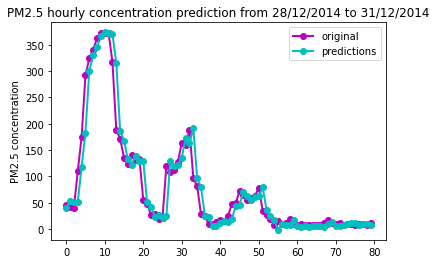

In [118]:
# line plot of observed vs predicted
fig, ax = plt.subplots(1)
ax.plot(raw_values[:,0][-80:],'mo-', label='original',linewidth = 2 )
ax.plot(predictions_test[-80:] ,'co-', label='predictions',linewidth = 2)
#ax.axvline(x=len(train_scaled)+1,color='k', linestyle='--')
ax.legend(loc='upper right')
ax.set_title('PM2.5 hourly concentration prediction from 28/12/2014 to 31/12/2014')
ax.set_ylabel('PM2.5 concentration')
plt.show()